In [5]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd())) # Include ../SSD in path
import numpy as np
import torch
import matplotlib.pyplot as plt
from vizer.draw import draw_boxes
from tops.config import instantiate, LazyConfig
from ssd import utils
np.random.seed(0)

In [6]:
config_path = "../configs/_visualize_transforms.py"
cfg = LazyConfig.load(config_path)
cfg.train.batch_size = 1

# Remove GroundTruthBoxesToAnchors transform
if cfg.data_train.dataset._target_ == torch.utils.data.ConcatDataset:
    for dataset in cfg.data_train.dataset.datasets:
        dataset.transform.transforms = dataset.transform.transforms[:-1]
else:
    cfg.data_train.dataset.transform.transforms = cfg.data_train.dataset.transform.transforms[:-1]
dataset = instantiate(cfg.data_train.dataloader)
gpu_transform = instantiate(cfg.data_train.gpu_transform)
image_mean = torch.tensor(cfg.data_train.gpu_transform.transforms[0].mean).view(1, 3, 1, 1)
image_std = torch.tensor(cfg.data_train.gpu_transform.transforms[0].std).view(1, 3, 1, 1)
sample = next(iter(dataset))
sample = gpu_transform(sample)

In [7]:

print("The first sample in the dataset has the following keys:", sample.keys())
for key, item in sample.items():
    print(
        key, ": shape=", item.shape if hasattr(item, "shape") else "", 
        "dtype=", item.dtype if hasattr(item, "dtype") else type(item), sep="")


The first sample in the dataset has the following keys: dict_keys(['image', 'boxes', 'labels', 'width', 'height', 'image_id', 'img_path'])
image: shape=torch.Size([1, 3, 128, 1024])dtype=torch.float32
boxes: shape=torch.Size([1, 13, 4])dtype=torch.float32
labels: shape=torch.Size([1, 13])dtype=torch.int64
width: shape=torch.Size([1])dtype=torch.int64
height: shape=torch.Size([1])dtype=torch.int64
image_id: shape=torch.Size([1])dtype=torch.int64
img_path: shape=dtype=<class 'list'>


/var/folders/r9/5r0c_f5s0kg0m5r4rcpytjpw0000gn/T/ipykernel_92997/3122437458.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


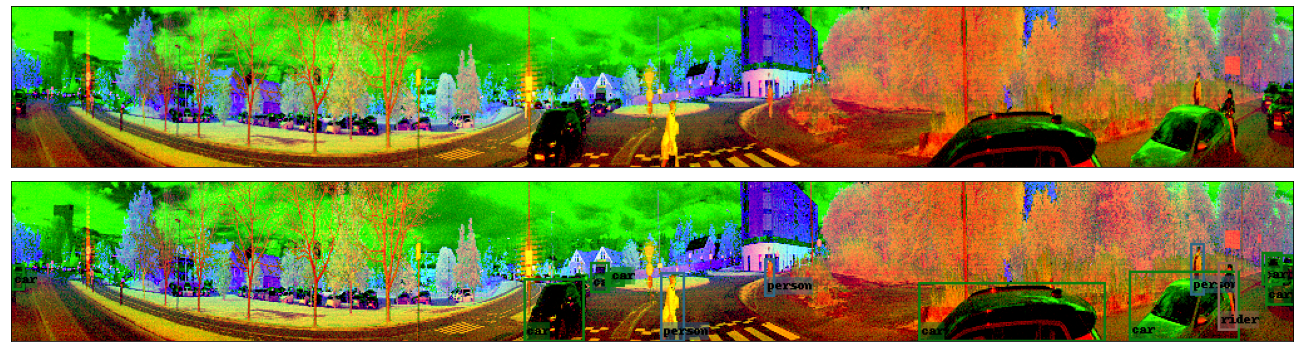

In [8]:
image_id = sample["image_id"][0].cpu().numpy().tolist()
image = (sample["image"] * image_std + image_mean)
image = (image*255).byte()[0]
boxes = sample["boxes"][0]
boxes[:, [0, 2]] *= image.shape[-1]
boxes[:, [1, 3]] *= image.shape[-2]
im = image.permute(1, 2, 0).cpu().numpy()
im = draw_boxes(im, boxes.cpu().numpy(), sample["labels"][0].cpu().numpy().tolist(), class_name_map=cfg.label_map)
original_im = plt.imread(f"{sample['img_path'][0]}")

# Plot
fig, (img1, img2) = plt.subplots(2, figsize=(30, 5))
img1.get_xaxis().set_visible(False)
img1.get_yaxis().set_visible(False)
img2.get_xaxis().set_visible(False)
img2.get_yaxis().set_visible(False)
fig.tight_layout()
img1.imshow(original_im)
img2.imshow(im)
fig.show()